In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math

In [2]:
# all values between 0 and 1
file = r'carbon_nanotubes.csv'
df = pd.read_csv(file, delimiter=';', header=None, decimal=',', skiprows=1)
x_train = df.drop([0,1], axis=1).values

In [3]:
print('data shape: ', x_train.shape)
m = x_train.shape[0]
n = x_train.shape[1]
print('No of training examples: ', m)
print('No of features: ', n)

data shape:  (10721, 6)
No of training examples:  10721
No of features:  6


In [10]:
def random_mini_batch(X, Y, mini_batch_size = None):
    '''xxxxxxxxxxxxxxxxxxxxxxx'''
    if mini_batch_size==None:
        return print('Need to specify a mini_batch_size.')
    else:
        
        m = X.shape[0]
        
        mini_batches = []
         
        # shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :]#.reshape(m,1) if this was a label vector of shape(m, 1)
        
        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
        
            mini_batch_X = shuffled_X[k * mini_batch_size: (k + 1) * mini_batch_size, :]
            mini_batch_Y = shuffled_Y[k * mini_batch_size: (k + 1) * mini_batch_size, :]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X =shuffled_X[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch_Y =shuffled_Y[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
            
        return mini_batches

In [4]:
# tf.reset_default_graph()
layer1 = 5
layer2 = 3
layer3 = 5
layer4 = n

initializer = tf.contrib.layers.variance_scaling_initializer() # This is a He initializtion


W1 = tf.get_variable(name='W1', shape=[n, layer1], initializer=initializer)
W2 = tf.get_variable(name='W2', shape=[layer1, layer2], initializer=initializer)
W3 = tf.get_variable(name='W3', shape=[layer2, layer3], initializer=initializer)
W4 = tf.get_variable(name='W4', shape=[layer3, layer4], initializer=initializer)

b1 = tf.zeros(shape=[1, layer1], name='b1')
b2 = tf.zeros(shape=[1, layer2], name='b2')
b3 = tf.zeros(shape=[1, layer3], name='b3')
b4 = tf.zeros(shape=[1, layer4], name='b4')

In [5]:
def encoder(input_placeholder):
    '''Create encoder which outputs the latent vector.
    
    Arguments:
    input_placeholder -- tensor, shape[None, m]
    
    Return:
    latent_vector -- tensor, activation of shape[None, layer2]'''
    
    # linear -> non-linear
    Z1 = tf.add(tf.matmul(input_placeholder, W1), b1) # linear
    A1 = tf.nn.relu(Z1) # non-linear
    
    Z2 = tf.add(tf.matmul(A1, W2), b2)
    latent_vector = tf.nn.relu(Z2)
    
    return latent_vector

In [6]:
def decoder(latent_tensor):
    '''Decode the encoder.
    
    Arguments:
    latent_vec -- tensor, shape[None, layer2]
    
    Return:
    output_layer -- tensor, shape[None, n]'''
    Z3 = tf.add(tf.matmul(latent_tensor, W3), b3)
    A3 = tf.nn.relu(Z3)
    
    # Use a sigmoid activation our original data is between 0,1
    Z4 = tf.add(tf.matmul(A3, W4), b4)
    output_layer = tf.nn.sigmoid(Z4)
    return output_layer

In [61]:
learning_rate = 0.001
epochs = 2000
mini_batch_size = 128

X = tf.placeholder(dtype=tf.float32, shape=[None, n], name='input')

encoded_out = encoder(X)
reconstruction = decoder(encoded_out)

cost = tf.reduce_mean(tf.square(tf.subtract(X, reconstruction)))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.global_variables_initializer()

losses = []

with tf.Session() as sess:
    sess.run(init)
    
    
    for epoch in range(epochs):  
        epoch_loss = 0
        
        num_mini_batches = int(m/mini_batch_size)  # No. of mini_batches that have mini_batch size.
        
        minibatches = random_mini_batch(x_train, x_train, mini_batch_size=mini_batch_size)  # inibatches is a list of tuples.
        
        for minibatch in minibatches:
            
            (minibatch_X, _) = minibatch
            
            _, minibatch_loss = sess.run([optimizer, cost], feed_dict={X: minibatch_X})
            
            epoch_loss += minibatch_loss/num_mini_batches
        
        if epoch % 5 == 0:
            losses.append(epoch_loss)
        if epoch % 100 == 0:
            print('epoch {} has loss of {}'.format(epoch, epoch_loss))

epoch 0 has loss of 0.0845633671585336
epoch 100 has loss of 0.038846046719924525
epoch 200 has loss of 0.037740976044751066
epoch 300 has loss of 0.03762571497943745
epoch 400 has loss of 0.03752609802387565
epoch 500 has loss of 0.037501470758074744
epoch 600 has loss of 0.0374481433396598
epoch 700 has loss of 0.037366054144250344
epoch 800 has loss of 0.03733628555144888
epoch 900 has loss of 0.03729753604674915
epoch 1000 has loss of 0.037240731339138654
epoch 1100 has loss of 0.037207816087876454
epoch 1200 has loss of 0.0371243144239647
epoch 1300 has loss of 0.037072545366294424
epoch 1400 has loss of 0.03698387012693537
epoch 1500 has loss of 0.036935740318822574
epoch 1600 has loss of 0.036873009100735904
epoch 1700 has loss of 0.03681975630033448
epoch 1800 has loss of 0.03679333777582072
epoch 1900 has loss of 0.036769799641277426


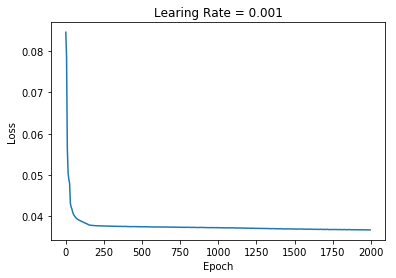

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.plot(np.arange(0, epochs, 5), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax=plt.title('Learing Rate = ' + str(learning_rate))